<a href="https://colab.research.google.com/github/ethanchen1301/SSDraw/blob/main/SSDraw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
%%capture
#@title SSDraw
#@markdown Installing the necessary dependencies can take 1-2 minutes.

# first install dssp
#!sudo yes | apt-get install dssp
!wget https://github.com/cmbi/dssp/archive/refs/tags/2.3.0.tar.gz
!tar -zxvf 2.3.0.tar.gz
%cd dssp-2.3.0
!./autogen.sh
!./configure
!make
!make mkdssp
!sudo make install
%cd ../
!mkdssp --version

# install necessary dependencies
!pip install Bio
!pip install matplotlib
!pip install numpy

import matplotlib.patches as mpatch
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.path as mpath
import matplotlib
import numpy as np
from Bio import pairwise2
import sys, os, string, math, re
from matplotlib import rcParams
import argparse
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP
from Bio.Align import substitution_matrices
from Bio import AlignIO
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from Bio.SeqUtils import seq1
import warnings, textwrap

def gap_sequence(seq, extra_gaps):
    # seq can be a list or a string, anything that can be indexed
    # extra gaps is a list of length two [x,y],
    # where x is the number of characters to remove from the beginning
    # and y the number of characters to remove from the end
    new_seq = seq
    if extra_gaps[1] != 0:
        new_seq = new_seq[:-extra_gaps[1]]
    return new_seq[extra_gaps[0]:]

def NormalizeData(data):
    if np.min(data) == np.max(data):
        warnings.warn("Warning: scores are the same for all residues")
        return data
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def coords2path(coord_set1):

    coords_f1 = []
    instructions1 = []

    for c in coord_set1:
        for n in range(len(c)):
            coords_f1.append(c[n])
            if n == 0:
                instructions1.append(1)
            else:
                instructions1.append(2)

    return coords_f1, instructions1

def build_loop(loop,idx,ssidx,linelen,nlines,loop_coords,prev_ss,next_ss, z=1,clr='r',mat=0,size=75):

    i0 = loop[0]
    if loop[0] != 0 and prev_ss != "B":
        i0 = loop[0]-1
    else:
        i0 = loop[0]
    i1 = loop[1]+2
    if loop[1] == linelen-1:
        i1 += 2

    o = 2
    if idx == nlines-1:
        o = 0
    if next_ss == "B":
        o = -1.5
    if next_ss == None:
        o=-4.1

    rectangle = mpatch.Rectangle((i0/6.0,-0.25-5.5*idx+2.0*ssidx),(i1-i0+o)/6.0,0.5,
                                  fc=clr,ec='k',zorder=0)

    plt.gca().add_patch(rectangle)

    loop_coords.append(rectangle.get_xy())

    if isinstance(mat,np.ndarray):
        im = plt.imshow(mat,extent=[0.0,size,0.5,3.0],cmap=CMAP,interpolation='none',zorder=0)
        im.set_clip_path(rectangle)

def build_strand(strand,idx,ssidx,strand_coords,next_ss,z=1,clr='r',imagemat=0,size=75):

    delta = 0 if next_ss == None else 1
    arrow=mpatch.FancyArrow(strand[0]/6.0,-5.5*idx+2.0*ssidx,(strand[1]-strand[0]+delta)/6.0,0,
                            width=1.0,fc=clr,linewidth=0.5,ec='k',zorder=z,head_width=2.0,
                            length_includes_head=True,head_length=2.0/6.0)

    plt.gca().add_patch(arrow)

    strand_coords.append(arrow.get_xy())


def build_helix(helix,idx,ssidx,coord_set1, coord_set2, clr='r',size=37.5,z=1,bkg=(0.195,0,0.051),imagemat=0):

    i = helix
    l = i[1]-i[0]+1
    points = [[i[0]/6.0,-0.25-5.5*idx+2.0*ssidx],[i[0]/6.0+1.0/6,0.75-5.5*idx+2.0*ssidx],\
              [i[0]/6.0+2.0/6,0.75-5.5*idx+2.0*ssidx],[i[0]/6.0+1.0/6,-0.25-5.5*idx+2.0*ssidx]]
    hlx = plt.Polygon(points,fc=clr,ec='k',zorder=1)
    coords= hlx.get_xy()
    coord_set2.append(coords)

    for j in range((l-2)-1):
        if j % 2 == 0:
            points = [[i[0]/6.0+(1.0+j)/6,0.75-5.5*idx+2.0*ssidx],
                      [i[0]/6.0+(2.0+j)/6,0.75-5.5*idx+2.0*ssidx],
                      [i[0]/6.0+(3.0+j)/6,-0.75-5.5*idx+2.0*ssidx],
                      [i[0]/6.0+(2.0+j)/6,-0.75-5.5*idx+2.0*ssidx]]
            coord_set1.append(points+[points[0]])
            hlx = mpatch.Polygon(points,fc=bkg,zorder=0)

        else:
            points = [[i[0]/6.0+(1.0+j)/6,-0.75-5.5*idx+2.0*ssidx],
                      [i[0]/6.0+(2.0+j)/6,-0.75-5.5*idx+2.0*ssidx],
                      [i[0]/6.0+(3.0+j)/6,0.75-5.5*idx+2.0*ssidx],
                      [i[0]/6.0+(2.0+j)/6,0.75-5.5*idx+2.0*ssidx]]
            coord_set2.append(points+[points[0]])
            hlx = mpatch.Polygon(points,fc=clr,zorder=z)


    if (l-2-1)%2 == 1:

        points = [[i[1]/6.0-1.0/6,-0.75-5.5*idx+2.0*ssidx],[i[1]/6.0,-0.75-5.5*idx+2.0*ssidx],\
                  [i[1]/6.0+1.0/6,0.25-5.5*idx+2.0*ssidx],[i[1]/6.0,0.25-5.5*idx+2.0*ssidx]]

        coord_set2.append(points+[points[0]])
        hlx = mpatch.Polygon(points,fc=clr,zorder=0)

    else:
        points = [[i[1]/6.0-1.0/6,0.75-5.5*idx+2.0*ssidx],[i[1]/6.0,0.75-5.5*idx+2.0*ssidx],\
                  [i[1]/6.0+1.0/6,-0.25-5.5*idx+2.0*ssidx],[i[1]/6.0,-0.25-5.5*idx+2.0*ssidx]]
        coord_set1.append(points+[points[0]])

        hlx = plt.Polygon(points,fc=bkg,zorder=10)

def SS_breakdown(ss):

    i = 0
    curSS = ''
    jstart = -1
    jend = -1

    strand = []
    loop = []
    helix = []
    ssbreak = []

    ss_order = []
    ss_bounds = []

    last_ss = ''

    SS_equivalencies = {'H':['H'],
                        '-':['-'],
                        'S':[' ','S','C','T','G','I','P'],
                        ' ':[' ','S','C','T','G','I','P'],
                        'C':[' ','S','C','T','G','I','P'],
                        'T':[' ','S','C','T','G','I','P'],
                        'G':[' ','S','C','T','G','I','P'],
                        'I':[' ','S','C','T','G','I','P'],
                        'P':[' ','S','C','T','G','I','P'],
                        'E':['E','B'],
                        'B':['E','B']}

    cur_SSDict = {'H':'helix',
                  '-':'break',
                  'E':'strand',
                  'B':'strand'}

    for i in range(len(ss)):

        if i == 0:
            curSS = SS_equivalencies[ss[i]]
            jstart = i
            if ss[i] in cur_SSDict.keys():
                last_ss = cur_SSDict[ss[i]]
            else:
                last_ss = 'loop'
            continue

        if ss[i] in curSS:
            jend = i

        if ss[i] not in curSS or i == len(ss)-1:


            if 'E' in curSS and jend-jstart+1 >= 3:
                strand.append((jstart,jend))
                ss_bounds.append((jstart,jend))
                ss_order.append('E')
                last_ss = 'strand'
            elif 'H' in curSS and jend-jstart+1 >=4:
                helix.append((jstart,jend))
                ss_bounds.append((jstart,jend))
                ss_order.append('H')
                last_ss = 'helix'
            elif ' ' in curSS and last_ss !='loop':
                if jend < jstart:
                    jend = jstart
                loop.append((jstart,jend))
                ss_bounds.append((jstart,jend))
                ss_order.append('L')
                last_ss = 'loop'
            elif '-' in curSS:
                if jend < jstart:
                    jend = jstart
                ssbreak.append((jstart,jend))
                ss_bounds.append((jstart,jend))
                ss_order.append('B')
                last_ss = 'break'
            elif last_ss == 'loop':
                if jend < jstart:
                    jend = jstart
                if len(loop) > 0:
                    jstart = loop[-1][0]
                    loop = loop[0:-1]
                    ss_bounds = ss_bounds[0:-1]
                    ss_order = ss_order[0:-1]
                loop.append((jstart,jend))
                ss_bounds.append((jstart,jend))
                ss_order.append('L')
                last_ss = 'loop'
            else:
                if jend < jstart:
                    jend = jstart
                loop.append((jstart,jend))
                ss_bounds.append((jstart,jend))
                ss_order.append('L')
                last_ss = 'loop'

            jstart = i
            curSS = SS_equivalencies[ss[i]]
    return strand,loop,helix, ssbreak, ss_order, ss_bounds


def updateSS(ss,seq,alignment):

    ss_u = ''

    j = 0

    for i in range(len(alignment)):
        if alignment[i] == '-':
            ss_u += '-'
        else:
            ss_u += ss[j]
            j += 1
            # if j == len(ss):  # check if reached the end of secondary structure annotation
            #    return ss_u

    return ss_u


def SS_align(alignment,ID,seq,ss,i_start,i_end):

    a_seq = ''
    seq_found = 0

    for i in alignment:

        if seq_found and i[0] == '>':
            break

        if i[0] == '>' and bool(re.search(ID.lower(), i.lower())):
            seq_found = 1
            continue

        if seq_found and i[0] != '>':
            a_seq += i

    if i_end != 0:
        i_end = len(a_seq)-i_end-1

    a_seq = gap_sequence(a_seq, [i_start,i_end])


    a = pairwise2.align.localxs(seq,a_seq,-1,-0.5)

    # check if the dssp annotation has any extra residues not in the fasta alignment
    if a[0][1] != a_seq:
        print("extra residues in pdb found\n")

    # check how many gap marks are at the end and beginning of the original alignment
    # (a_seq) and compare to the amount found in a[0][1]
    a_seq_gaps = [0,0]
    new_aln_gaps = [0,0]
    for i in range(len(a_seq)):
        if a_seq[i] == "-":
            a_seq_gaps[0] += 1
        else:
            break
    for i in range(len(a_seq)-1, -1, -1):
        if a_seq[i] == "-":
            a_seq_gaps[1] += 1
        else:
            break

    for i in range(len(a[0][1])):
        if a[0][1][i] == "-":
            new_aln_gaps[0] += 1
        else:
            break
    for i in range(len(a[0][1])-1, -1, -1):
        if a[0][1][i] == "-":
            new_aln_gaps[1] += 1
        else:
            break

    extra_gaps = [new_aln_gaps[0]-a_seq_gaps[0], new_aln_gaps[1]-a_seq_gaps[1]]

    SS_updated = updateSS(ss,seq,a[0][0])

    SS_updated_new = gap_sequence(SS_updated, extra_gaps)
    a_new = gap_sequence(a[0][1], extra_gaps)

    return SS_updated_new, a_new, extra_gaps, i_start, i_end

def plot_coords(coords,z=10):

    coords_f1, instructions1 = coords2path(coords)

    path = mpath.Path(np.array(coords_f1),np.array(instructions1))
    patch = mpatch.PathPatch(path, facecolor='none',zorder=z)
    plt.gca().add_patch(patch)
    im = plt.imshow(mat,extent=[0.0,sz,0.5,3.0],cmap=CMAP,interpolation='none')
    im.set_clip_path(patch)

def run_dssp(pdb_path, id, chain):

    ss_seq = ""
    aa_seq = ""

    p = PDBParser()
    structure = p.get_structure(id, pdb_path)
    model = structure[0]
    dssp = DSSP(model, pdb_path)
    a_key = list(dssp.keys())
    for key in a_key:
        if key[0] == chain:
            aa_seq+=dssp[key][1]
            if dssp[key][2] == "-":
                ss_seq+="C"
            else:
                ss_seq+=dssp[key][2]

    #sys.exit()
    return [ss_seq,aa_seq]

def convert2horiz(dssp_file, pdbseq):

    ss_seq = ""
    aa_seq = ""

    with open(dssp_file, "r") as f:
        lines = f.readlines()

    dssp_ext = dssp_file.split(".")[-1]

    if dssp_ext == "horiz":
        ss_seq = lines[0].rstrip('\n')
        aa_seq = lines[1].rstrip('\n')

    elif dssp_ext == "dssp":
        start_read = False
        for line in lines:
            if start_read:
                if line[13] == "!":
                    start_read = False
                    continue
                ss_seq += line[16]
                aa_seq += line[13]
            if line.split()[0] == "#":
                start_read = True

    else:
        raise Exception("DSSP file extension not recognized: must be in .dssp or .horiz format")

    return [ss_seq,aa_seq]

def score_column(msa_col, threshold=0):

    blosum62 = substitution_matrices.load("BLOSUM62")
    # find consensus of the column
    aa_count = {"A": 0, "R": 0, "N": 0, "D": 0, "C": 0, "Q": 0, "E": 0,
                "G": 0, "H": 0, "I": 0, "L": 0, "K": 0, "M": 0, "F": 0,
                "P": 0, "S": 0, "T": 0, "W": 0, "Y": 0, "V": 0}
    for i in msa_col:
        try:
            aa_count[i] += 1
        except:
            pass
    consensus_aa = max(zip(aa_count.values(), aa_count.keys()))[1]

    conservation_count = 0
    for i in msa_col:
        if i in aa_count.keys():
            if blosum62[consensus_aa][i] >= 0:
                conservation_count += 1

    return conservation_count/len(msa_col)

def parse_color(args,seq_wgaps,pdbseq,bfactors,msa):
    CMAP = ""
    if args.color in mcolors.BASE_COLORS.keys() or args.color in mcolors.CSS4_COLORS.keys() or args.color in mcolors.XKCD_COLORS.keys():
        CMAP = ListedColormap([args.color])
    elif args.color[0] == "#":
        CMAP = ListedColormap([args.color])
    if args.conservation_score or args.bfactor or args.scoring_file:
        if len(args.color_map) == 1:
            CMAP = args.color_map[0]
        else:
            CMAP = ListedColormap(args.color_map)

    #bvals are to make the colormap; taken from input PDB
    bvals = []

    if args.mview:
        mview_colors = {"A": 0, "G": 0, "I": 0, "L": 0, "M": 0, "P": 0, "V": 0,
                        "F": 1, "H": 1, "W": 1, "Y": 1,
                        "K": 2, "R": 2,
                        "D": 3, "E": 3,
                        "S": 4, "T": 4,
                        "N": 5, "Q": 5,
                        "C": 6}
        mview_colors_hit = [0,0,0,0,0,0,0]

        mview_color_map = ["#33cc00","#009900","#cb0000","#0133ff","#0299fe","#6601cc","#ffff00","#808080"]

        for i in range(len(seq_wgaps)):
            try:
                m = mview_colors[seq_wgaps[i]]
                bvals.append(m)
                mview_colors_hit[m]+=1
            except:
                bvals.append(7)

        for i in range(len(mview_colors_hit)): # remove colors of residues not in sequence
            if mview_colors_hit[i] == 0:
                mview_color_map.pop(i)
                for j in range(len(bvals)):
                    if bvals[j] > i:
                        bvals[j] -= 1

        CMAP = ListedColormap(mview_color_map)

    elif args.scoring_file: # use custom scoring by residue
        # read in scoring file
        bvals_tmp = []
        scoring_seq = ""
        with open(args.scoring_file, "r") as g:
            lines = g.readlines()
        for line in lines:
            scoring_seq += line.split()[0]
            bvals_tmp.append(float(line.split()[1]))

        score_align = pairwise2.align.localxs(pdbseq,scoring_seq,-1,-0.5)

        j = 0
        for i in range(len(score_align[0][1])):
            if score_align[0][0][i] != "-":
                if score_align[0][1][i] != "-":
                    bvals.append(bvals_tmp[j])
                    j+=1
                else:
                    bvals.append(min(bvals_tmp))


    elif args.bfactor:  # score by bfactor
        bvals = [b for b in bfactors]

    elif args.conservation_score: # score by conservation score
        bvals = []
        for i in range(len(msa[0])):
            bvals.append(score_column([msa[j][i] for j in range(len(msa))]))

    else: # solid color
        bvals = [i for i in range(len(msa[0]))]

    if len(bvals) == len(pdbseq):
        # remove extra residues
        pdbseq = gap_sequence(pdbseq, extra_gaps)
        bvals = gap_sequence(bvals, extra_gaps)

        bvalsf = []
        j = 0
        for i in range(len(ss_order)):
            #Make secondary structure chunk
            #If chunk is a chain break, assign each break to the lowest B-factor
            #Else assign each position of aligned secondary structure to its respective
            #CA B-factor and iterate through list of B-factors so that register is
            #maintained
            if ss_order[i] == 'B':
                bvalsf += [min(bvals)]*(ss_bounds[i][1]-ss_bounds[i][0]+1)

            else:
                bvalsf += bvals[j:j+ss_bounds[i][1]-ss_bounds[i][0]+1]
                j += ss_bounds[i][1]-ss_bounds[i][0]+1

        bvals = bvalsf

    return CMAP, bvals

def read_pdb(id,args):
    pdbseq = ''
    p = PDBParser()
    bfactors = []
    structure = p.get_structure(id, args.pdb)
    model = structure[0]
    for chain in model:
        if chain.get_id() == args.chain_id:

            for residue in chain:
                for atom in residue:
                    if atom.name == "CA":
                        bfactors.append(atom.bfactor)
                        pdbseq += seq1(residue.get_resname())
                        break
    return bfactors, pdbseq

description='''
----------------

SSDraw is a program that generates publication-quality protein secondary structure diagrams from three-dimensional protein structures. To depict relationships between secondary structure and other protein features, diagrams can be colored by conservation score, B-factor, or custom scoring.

SSDraw also has a colab notebook available at https://github.com/ethanchen1301/SSDraw.



Installation:

SSDraw requires the biopython module:
        pip install biopython

SSDraw also requires the DSSP program to be installed in order to generate secondary structure annotations.
        sudo apt-get install dssp

Alternatively, you can install DSSP either through conda (conda install -c salilab dssp), or you can follow the instructions on their github page to make a local installation:
https://github.com/cmbi/dssp.



Instructions:
SSDraw requires 4 arguments:
1. --fasta: the file name sequence or alignment file in fasta format.
2. --name: the id of the sequence in the fasta file corresponding to your protein of interest.
3. --pdb: the file name of the pdb file of your protein
4. --output: the output file name to use

Example 1:
    python3 ../SSDraw.py --fasta 1ndd.fasta --name 1ndd --pdb 1ndd.pdb --output 1ndd_out

Coloring options:
SSDraw uses a gradient to color each position in the alignment by a certain score. The user can choose which scoring system to use, and they can also choose which colormap.

Scoring:
-conservation_score: score each position in the alignment by conservation score.
-bfactor: score each residue in the pdb by bfactor
-scoring_file: score each residue by a custom scoring file prepared by the user
-mview: color each residue by the mview coloring system

Example 2: Score by conservation
    python3 ../SSDraw.py --fasta aligned.fasta --name 1ndd --pdb 1ndd.pdb --output 1ndd_conservation -conservation_score

Example 3: Score by bfactor
    python3 ../SSDraw.py --fasta 1ndd.fasta --name 1ndd --pdb 1ndd.pdb --output 1ndd_bfactor -bfactor

Choosing a colormap:
The default colormap for SSDraw is inferno. The user can select one of the matplotlib library color maps or simply list a set of colors they'd like to use with the --color_map option. Alternatively, the user can select a single color with the --color option and SSDraw will use that color on the whole image.

Example 4: Custom scoring file with custom color map
    python3 ../SSDraw.py --fasta 2kdl.fasta --name 2kdl --pdb 2kdl.pdb --output 2kdl_out --scoring_file 2kdl_scoring.txt --color_map black cyan

DSSP files:
Normally, SSDraw will generate a DSSP annotation from the PDB file, but if you have a DSSP file you would like to use, you can upload it and input the file name in Options.

--start and --end:
If you want SSDraw to draw only a portion of your alignment, you can specify the start and/or end points using the --start and --end options respectively. The argument for these options correspond to the index of the alignment position, not to the residue position numbers.

Example 5: Choose subregion of alignment to run SSDraw on
    python3 ../SSDraw.py --fasta aligned.fasta --name 1ndd --pdb 1ndd.pdb --output 1ndd_conservation_cropped -conservation_score --start 80 --end 132
----------------

Running on multiple pdbs:
In order to rapidly generate multiple images with SSDraw, we recommend writing shell scripts comprised of commands like those shown in the above examples. For examples of such shell scripts, see one of the shell scripts in /figures/.
'''

&#8592;

&#8592;

You will need to upload the sequence and pdb files to this session.
Click on the Files icon to the left then choose 'upload to session storage'

Once the files are uploaded type the file names below.

&#8592;

&#8592;

In [ ]:
%%capture

## allow user to upload from their computer

from google.colab import files
#@title Define variables
#@markdown ##Required:
fasta_file = "aligned.fasta" #@param {type:"string"}
#@markdown  - Type in the name of your sequence/alignment file here. For more information see [instructions](#Instructions)
name = '1ndd'  #@param {type:"string"}
pdb_file = "1ndd.pdb" #@param {type:"string"}
#@markdown  - Type in the name of your pdb file here. For more information see [instructions](#Instructions)
output = "1ndd" #@param {type:"string"}
salign = open(fasta_file).read().splitlines() # every line from the alignment

#@markdown ##Options:
scoring_file=""
chain_id = 'A'  #@param {type:"string"}
output_file_type = "png" #@param ["png", "ps", "eps", "tif"] {type:"string"}
image_dpi = 600 #@param {type:"raw"}
dssp_file ="" #@param {type:"string"}
coloring = "gradient" #@param ["solid", "gradient", "mview"]
solid_color = "white" #@param {type:"string"}
gradient_color_map = "inferno" #@param {type: "string"}
scoring = "by conservation score" #@param ["by conservation score","by bfactor", "custom"]
scoring_file = "" #@param {type: "string"}

id = name
color = solid_color
color_map = gradient_color_map

f = run_dssp(pdb_file, id, chain_id)

# custom arg parse for colab notebook
class ArgParser():
    def __init__(self, fasta, name, pdb, output, dssp=None,
                 chain_id = "A", color_map=["inferno"], scoring_file=None,
                 color="white", conservation_score=False, output_file_type="png",
                 bfactor=False,mview=False,dpi=600,start=0,end=0):
        self.fasta = fasta
        self.name = name
        self.pdb = pdb
        self.output = output
        self.dssp = dssp
        self.chain_id = chain_id
        self.color_map = color_map
        self.scoring_file = scoring_file
        self.color = color
        self.conservation_score = conservation_score
        self.output_file_type = output_file_type
        self.bfactor = bfactor
        self.mview = mview
        self.dpi = dpi
        self.start = start
        self.end = end

# parse arguments
args = ArgParser(fasta_file,name,pdb_file,output,dssp=dssp_file,
                   chain_id=chain_id,color_map=gradient_color_map,
                   scoring_file=None, color=solid_color,
                 conservation_score=False, output_file_type=output_file_type,
                 bfactor=False,mview=False,dpi=600,start=0,end=0)

# parse coloring and scoring
if coloring != "solid":
    args.color_map = gradient_color_map.split()
    if coloring == "mview":
        args.mview = True
    elif scoring == "by conservation score":
        args.conservation_score = True
    elif scoring == "by bfactor":
        args.bfactor = True
    elif scoring == "custom":
        args.scoring_file = scoring_file

In [ ]:
#@title Choose subregion of alignment to run SSDraw on
#@markdown If you want to run SSDraw on the entire alignment, run this cell, but leave these sliders unchanged.

#@markdown IMPORTANT: These are the numberings based on the alignment, not on the numbering in the pdb file.
## Change numbering to the numbering in the pdb

# alignment subsection
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

display_seq = ""
display_seq_found = False
for i in salign:
        if display_seq_found and i[0] == '>':
            break
        if i[0] == '>' and bool(re.search(id.lower(), i.lower())):
            display_seq_found = True
            continue

        if display_seq_found and i[0] != '>':
            display_seq += i

def aln_sub(start=0,end=len(display_seq)):
  display(display_seq[start:end+1])
  return [start,end]

w = interactive(aln_sub, start=(0,len(display_seq)), end=(0,len(display_seq)))
display(w)

interactive(children=(IntSlider(value=0, description='start', max=240), IntSlider(value=240, description='end'…


Running for: 1ndd


/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 592
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 592
  warnings.warn(


Saving output to output/1ndd.png...


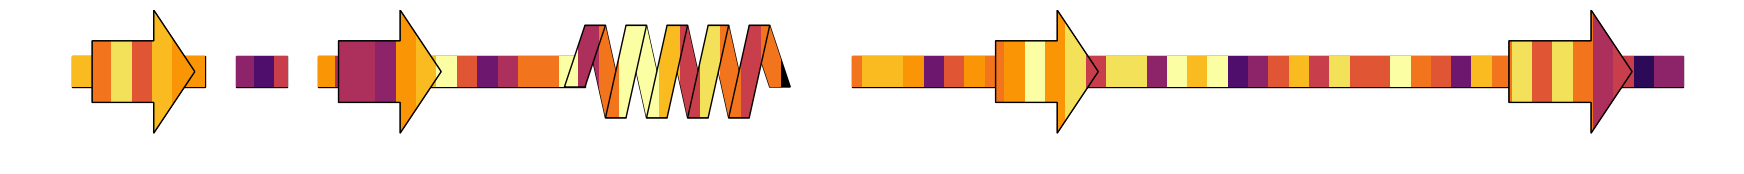

In [ ]:
#@title Run SSDraw

# parse start and end
start,end = w.result
args.start = start
if end == len(display_seq):
    args.end = 0
else:
    args.end = end

# preface run
print("\nRunning for: "+id)

# read in amino acid sequence from PDB
bfactors, pdbseq = read_pdb(id,args)

if args.dssp:
    # get secondary structure from pre-existing DSSP annotation
    '''f = convert2horiz(args.dssp)
    pdbseq = f[1]'''
    f = convert2horiz(args.dssp,pdbseq)
    #print(f)
    #sys.exit()
else:
    # run the dssp executable
    f = run_dssp(args.pdb, id, chain_id)
    #print(f)

nlines = 1
salign = open(args.fasta).read().splitlines()

if args.start > args.end:
    raise Exception("--start cannot be greater than --end")

#####Align secondary structure to match input sequence alignment
ss_wgaps,seq_wgaps,extra_gaps,i_start,i_end = SS_align(salign,args.name,f[1],f[0],args.start,args.end)

#Break down secondary structure classifications in to continuous
#chunks of helix, strand, and coil
strand,loop,helix,ss_break,ss_order,ss_bounds = SS_breakdown(ss_wgaps)

msa = [gap_sequence(a, [i_start, i_end]) for a in AlignIO.read(open(args.fasta), "fasta")]

#Parse color and scoring args
CMAP, bvals = parse_color(args,seq_wgaps,pdbseq,bfactors,msa)

mat = np.tile(NormalizeData(bvals), (100,1))

#set figure parameters
sz = 0
c = 'none'
bc = 'none'

#set sizes of SS chunks
ss_prev = 0
for i in range(len(ss_order)):

    if ss_order[i] == 'H':
        ss_prev = ss_bounds[i][1]/6.0+1/6.0
    else:
        ss_prev = ss_bounds[i][1]/6.0

if ss_order[-1] == 'H':
    sz = ss_bounds[-1][1]/6.0+1/6.0
elif ss_order[-1] == 'E':
    sz = ss_bounds[-1][1]/6.0
elif ss_order[-1] == 'L':
    sz = (ss_bounds[-1][1])/6.0
elif ss_order[-1] == 'B':
    sz = (ss_bounds[-1][1])/6.0

#Plot secondary structure chunks
strand_coords = []
loop_coords = []
helix_coords1 = []
helix_coords2 = []

fig, ax = plt.subplots(ncols=1, figsize=(25,2+1.5*(nlines-1)))

for i in range(len(ss_order)):
    prev_ss = None
    next_ss = None
    if i != 0:
        prev_ss = ss_order[i-1]
    if i != len(ss_order)-1:
        next_ss = ss_order[i+1]

    if ss_order[i] == 'L':
        build_loop(ss_bounds[i],0,1,len(ss_wgaps),1,loop_coords,prev_ss,next_ss,z=0,clr=c,mat=mat,size=sz)
    elif ss_order[i] == 'H':
        build_helix(ss_bounds[i],0,1,helix_coords1,helix_coords2,z=i,clr=c,bkg=bc,imagemat=mat,size=sz)
    elif ss_order[i] == 'E':
        build_strand(ss_bounds[i],0,1,strand_coords,next_ss,z=i,clr=c,imagemat=mat,size=sz)

if len(strand_coords) != 0:
    plot_coords(strand_coords)
if len(helix_coords1) != 0 and len(helix_coords2) != 0:
    plot_coords(helix_coords1,z=0)
    plot_coords(helix_coords2)

plt.ylim([0.5,3])

plt.axis('off')
ax.set_aspect(0.5)

print("Saving output to output/{:}.{:}...".format(args.output, args.output_file_type))
if not os.path.exists("output"):
    os.makedirs("output")
plt.savefig("output/"+args.output+"."+args.output_file_type,bbox_inches='tight',dpi=args.dpi,transparent=True)


In [ ]:
#@title Download output files

!zip -r output.zip output # first, zip files
files.download("output.zip")# Then download zipped file

  adding: output/ (stored 0%)
  adding: output/1ndd.png (deflated 45%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Instructions <a name="Instructions"></a>
**Quick start**
1. Upload a pdb file and a sequence file in fasta format. To do this, click the folder icon on the left tab, and select the "upload files" option.
2. Fill out the arguments in the required section of "Define Variables." Input the sequence file name, name of the protein used in the fasta file, pdb file name, and output file name into their respective prompts. Leave the other options unchanged.
4. Press "Runtime" -> "Run all".
**Running on multiple PDBs**

Run the first cell titled "SSDraw". Then fill in the required inputs for your first pdb, and run the next three cells: "Define variables", "Choose subregion...", and "Run SSDraw". That will generate an image for your first PDB. To run again for the next pdb, edit the input section and rerun the same three cells "Define variables, "Choose subregion...", and "Run SSDraw". You do not need to rerun the first cell, since it is just for installing and importing the required libraries. Repeat this step for all PDBs. To download the final results, run the final cell titled "Download output files".

*Note*: If you are running SSDraw for multiple pdbs on a subregion of the alignment, you can skip rerunning the "Choose subregion..." cell. This will fix the subregion for all of your runs.

**File formats:**

The alignment file you use must be in fasta format.

If you use a custom file to score residues, write the file in the following format: every line includes first the one-letter amino acid code of the residue, followed by a space, and then the score for that residue.

**DSSP files:**

Normally, SSDraw will generate a DSSP annotation from the PDB file, but if you have a DSSP file you would like to use, you can upload it and input the file name in Options.

**Coloring:**

SSDraw provides both solid and gradient coloring. If you choose solid, you can pick which solid color to use by either typing a color name contained in matplotlib's color library or a hexcode (with a preceding #). If you choose gradient, SSDraw will use the gradient color map selected in the options section. The image will be colored in based on a per-residue score (see Scoring). SSDraw also provides the option to color based on the mview color map, which colors residues by their chemical property.

**Scoring**:

There are two scoring methods built into SSDraw: scoring by conservation score or scoring by b-factor. There are also two ways to use a custom scoring method. First, you can upload a scoring file following this file format: every line includes first a one-letter amino acid code, followed by a space, and then the score of that residue. Another way to use a custom scoring is to edit the b-factors of the C-alpha carbons in your pdb file, then choose score by b-factor.